# Rappel : Architecture d'un RAG

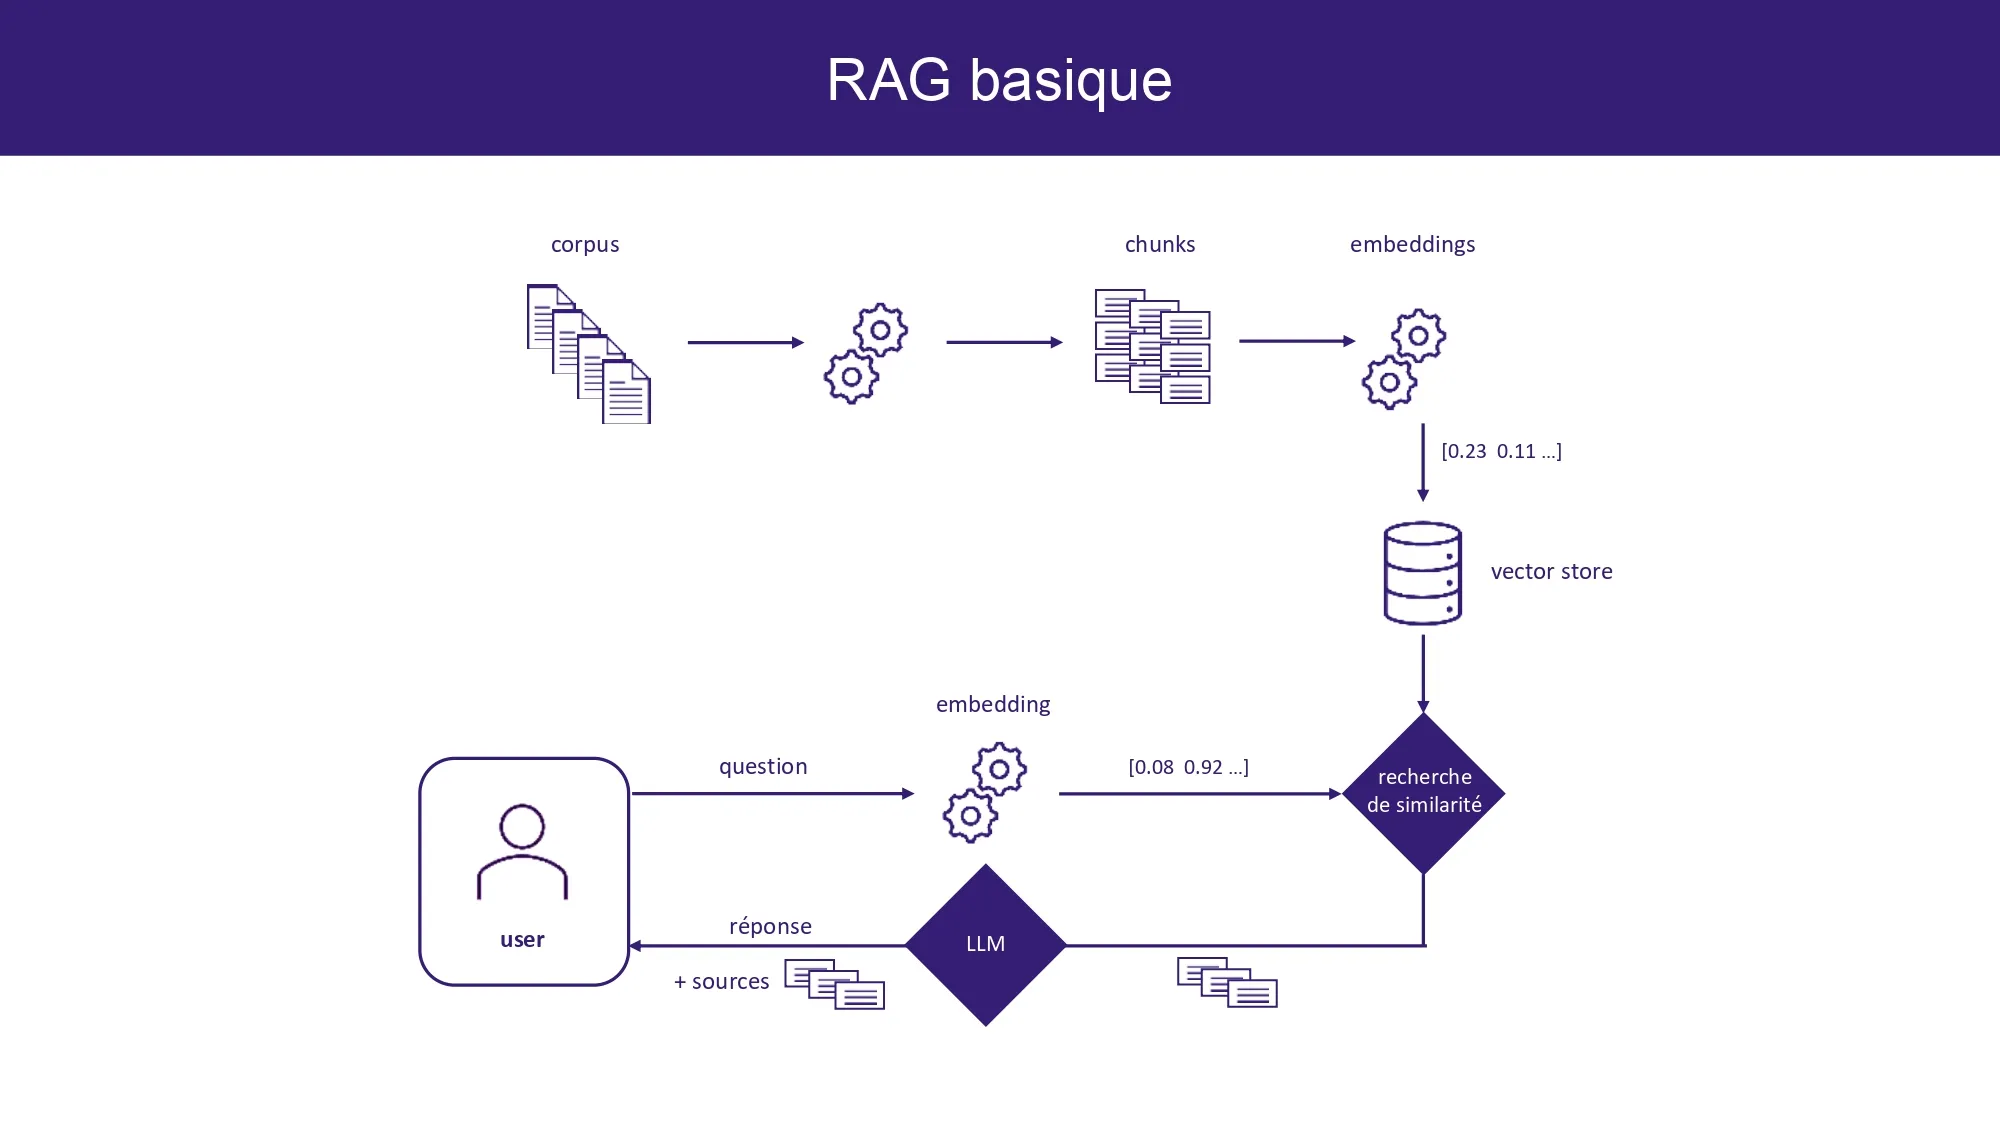

*source : reglo.ai*

# Installation des packages

In [2]:
!pip install langchain langchain_community tiktoken langchain_openai faiss-cpu


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import pandas as pd
import numpy as np
import openai
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from sklearn.metrics.pairwise import cosine_similarity

## Configuration d'OpenAI

In [5]:
OPENAI_API_KEY = "******"
openai.api_key = OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [6]:
embedding_model = "text-embedding-3-small"
llm_model = "gpt-4o-mini"

# 1. Modèles

## Modèle d'embedding

In [7]:
embedding = openai.embeddings.create(
    input="Je viens de créer mon premier embedding !",
    ### TO DO ###
    model=embedding_model
)

Regardez à quoi ressemble un embedding. Quelle dimension ont les embeddings générés ?

In [8]:
### TO DO ###
embedding

CreateEmbeddingResponse(data=[Embedding(embedding=[0.013990078121423721, -0.025976207107305527, -0.030434995889663696, -0.045414526015520096, 0.0010912135476246476, -0.04115613177418709, 0.05691219121217728, 0.006512838881462812, -0.02953321859240532, 0.003200058126822114, 0.055960312485694885, -0.02910737879574299, 0.0005049015744589269, -0.06582976877689362, 0.006512838881462812, 0.026427095755934715, -0.021542467176914215, -0.010902742855250835, 0.0074146161787211895, 0.0488462895154953, 0.014841757714748383, -0.05195241421461105, -0.02170528657734394, 0.027854910120368004, 0.03221350163221359, -0.06477769464254379, 0.0069136288948357105, 0.011923504993319511, -0.019162775948643684, -0.032964982092380524, 0.02246929332613945, -0.03203815594315529, -0.0027429070323705673, -0.01377715915441513, 0.0002970699861180037, -0.0011045210994780064, -0.0021933862008154392, 0.03103618137538433, -0.05370587110519409, 0.04834530130028725, 0.025112003087997437, 0.012142687104642391, 0.049697969108

In [9]:
def get_embedding(text):
    response = openai.embeddings.create(
        input=text,
        model=embedding_model
    )
    return response.data[0].embedding

Utilisez la cosine similarity pour comparer les similarités entre embeddings de phrases proches et de phrases éloignées

In [10]:
sentence_1 = "Adopter un chien, c’est accueillir un compagnon qui saura nous écouter sans juger et qui restera fidèle tout au long de sa vie."
embedding_1 = get_embedding(sentence_1)

In [11]:
sentence_2 = "Avoir un animal de compagnie permet de profiter d’une présence réconfortante au quotidien, car ils sont toujours là dans les bons comme dans les mauvais moments."
embedding_2 = get_embedding(sentence_2)

In [12]:
sentence_3 = "L’essor de l’intelligence artificielle transforme en profondeur de nombreux secteurs, de la médecine à l’industrie, en passant par l’éducation."
embedding_3 = get_embedding(sentence_3)

In [14]:
### TO DO ###
distance = cosine_similarity([embedding_1], [embedding_3])
print(distance)

[[0.18771594]]


## LLM

Utilisez l'API OpenAI pour requêter le modèle *gpt-4o-mini*

In [18]:
chat_response = openai.chat.completions.create(
    ### TO DO ###
    model=llm_model,
    messages = [
        {
            "role": "user",
            "content": "Qui es-tu ?",
        },
    ]
)

Regardez à quoi ressemble la réponse.

In [19]:
### TO DO ###
chat_response

ChatCompletion(id='chatcmpl-B0WEYMXXo5tHT3NFNLZ6AImIEhA3A', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Je suis un modèle d'intelligence artificielle développé par OpenAI, conçu pour répondre à des questions et fournir des informations sur une variété de sujets. Je n'ai pas de conscience ni d'identité propre, mais je suis ici pour aider ! Comment puis-je t'assister aujourd'hui ?", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1739463606, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_72ed7ab54c', usage=CompletionUsage(completion_tokens=59, prompt_tokens=11, total_tokens=70, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [21]:
chat_response.choices[0].message.content

"Je suis un modèle d'intelligence artificielle développé par OpenAI, conçu pour répondre à des questions et fournir des informations sur une variété de sujets. Je n'ai pas de conscience ni d'identité propre, mais je suis ici pour aider ! Comment puis-je t'assister aujourd'hui ?"

Jouez avec les paramètres du modèle

In [23]:
chat_response = openai.chat.completions.create(
    model=llm_model,
    ### TO DO ###
    temperature=0,
    messages = [
        {
            "role": "user",
            "content": "qui est le PDG de Diginamic ?",
        },
    ]
)
print(chat_response.choices[0].message.content)

Diginamic est une entreprise française spécialisée dans le développement de solutions numériques. Cependant, je n'ai pas d'informations actualisées sur le PDG de Diginamic après octobre 2021. Pour obtenir des informations récentes, je vous recommande de consulter le site officiel de l'entreprise ou des sources d'actualités fiables.


# 2. Creation du RAG

## Création du Vector Store

In [24]:
# url à scrapper
urls = [
    "https://www.diginamic.fr/lequipe-diginamic/"
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# définition des chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200,
    chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

Affichez le contenu de quelques chunks

In [25]:
### TO DO ###
doc_splits[4].page_content

'DIGINAMIC Qui sommes-nous ?Présentation de DiginamicL’Equipe DiginamicLe Digi’blogNos journées portes ouvertesPourquoi choisir Diginamic ?Nos partenairesAccessibilité de nos écolesLa réussite de nos apprenantsNos centres de formationNantesMontpellierLa formation à distance chez DiginamicLes formations Cycle de formationCycle Bachelor Développeur full stack et IA – Bac+3Les formations diplômantesDéveloppeur Web et mobile– Titre RNCP 5 (équivalent Bac+2)Technicien supérieur Systèmes et réseaux – Titre RNCP niveau 5 (équivalent Bac+2)Concepteur Développeur full stack – Titre RNCP 6'

Construisez la base vectorielle

In [26]:
embedding_model = OpenAIEmbeddings(model=embedding_model)

vectorstore = FAISS.from_documents(
    documents=doc_splits,
    ### TO DO ###
    embedding=embedding_model
)
vectorstore.save_local('diginamic')

## Definition du retriever

In [27]:
retriever = vectorstore.as_retriever()

In [28]:
# Test du retriever
retriever.invoke('qui est le PDG de Diginamic ?')

[Document(id='9a359fdd-77d1-44f3-b141-25bd892101e9', metadata={'source': 'https://www.diginamic.fr/lequipe-diginamic/', 'title': "L'Equipe Diginamic - Diginamic Formation", 'description': "Découvrez l'équipe Diginamic \r\nUne équipe composée de professionnels de la formation et de l'informatique à votre service et à votre écoute    Lionel \r\nPrésident Directeur Général  \r\nChristian \r\nDirecteur des Opérations\r\net de la Qualité  Harmonie \r\nChargée d'ingénierie Pédagogique  Isabelle", 'language': 'fr-FR'}, page_content="L'Equipe Diginamic - Diginamic Formation"),
 Document(id='2928cba1-76e5-485f-ad09-4e888fb44be4', metadata={'source': 'https://www.diginamic.fr/lequipe-diginamic/', 'title': "L'Equipe Diginamic - Diginamic Formation", 'description': "Découvrez l'équipe Diginamic \r\nUne équipe composée de professionnels de la formation et de l'informatique à votre service et à votre écoute    Lionel \r\nPrésident Directeur Général  \r\nChristian \r\nDirecteur des Opérations\r\net d

## Amélioration du LLM

In [29]:
# Initialisation du LLM
llm = ChatOpenAI(model=llm_model, temperature=0)

In [30]:
# Définition d'un prompt basique
template = """Réponds à la question

{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [31]:
# Définition de la chaîne de réponse
output_parser = StrOutputParser()

chain = (
   {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | output_parser
)

## Test du RAG

In [32]:
chain.invoke("qui est le PDG de Diginamic ?")

'Le PDG de Diginamic est Lionel.'

In [33]:
chain.invoke("qui es tu?")

"Je suis un assistant virtuel conçu pour répondre à vos questions et vous aider avec des informations. Je peux fournir des réponses sur divers sujets, y compris des détails sur des équipes, des entreprises, des formations, et bien plus encore. Comment puis-je vous aider aujourd'hui ?"